### Objective:
- Determine the results of the A/B test. Confirm that the test is actually negative.
- Derive factors that could cause the result of the A/B test.
- If an error was identified, design an algorithm that would catch similar errors in the future.
- Automate steps of the A/B test analysis

In [1]:
# Import the necessary libraries

# Import pandas and numpy
import numpy as np
import pandas as pd

# Import seaborn and matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Import two-sided t-test
from scipy.stats import ttest_ind

In [2]:
# Import the raw datasets

# Import the test data
test_df = pd.read_csv('test_table.csv')

# Import the user data
user_df = pd.read_csv('user_table.csv')

First, let's make sure the data is as we expect.

In [3]:
# Check for table information
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453321 entries, 0 to 453320
Data columns (total 9 columns):
user_id             453321 non-null int64
date                453321 non-null object
source              453321 non-null object
device              453321 non-null object
browser_language    453321 non-null object
ads_channel         181877 non-null object
browser             453321 non-null object
conversion          453321 non-null int64
test                453321 non-null int64
dtypes: int64(3), object(6)
memory usage: 31.1+ MB


In [4]:
test_df.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1


In [5]:
# Make sure the unique values are as expected
for col in ['source', 'device', 'browser_language', 'ads_channel', 
          'browser', 'conversion', 'test']:
    print (test_df[col].unique())

['Direct' 'Ads' 'SEO']
['Web' 'Mobile']
['ES' 'Other' 'EN']
[nan 'Google' 'Facebook' 'Bing' 'Yahoo' 'Other']
['IE' 'Chrome' 'Android_App' 'FireFox' 'Iphone_App' 'Safari' 'Opera']
[1 0]
[0 1]


In [6]:
# Convert the date column to datetime objects
test_df['date'] = pd.to_datetime(test_df['date'])

There doesn't appear to be anything particularly strange about the test data. There are null values in the ads_channel that represent that the user did arrive to the site via an ad.

Note that test=1 is the test group (local translation) and test=0 is the control group.

In [7]:
# Check for table information
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452867 entries, 0 to 452866
Data columns (total 4 columns):
user_id    452867 non-null int64
sex        452867 non-null object
age        452867 non-null int64
country    452867 non-null object
dtypes: int64(2), object(2)
memory usage: 13.8+ MB


In [8]:
for col in ['sex', 'age', 'country']:
    print(user_df[col].unique())

['M' 'F']
[20 27 23 29 31 21 49 24 22 18 37 25 26 28 54 19 33 36 38 34 35 32 39 41
 42 48 30 40 47 45 43 46 44 51 61 52 57 50 56 63 55 53 58 70 60 59 65 62
 64 68 67 66]
['Mexico' 'Nicaragua' 'Colombia' 'Venezuela' 'Spain' 'Ecuador' 'Paraguay'
 'Bolivia' 'Argentina' 'Peru' 'Chile' 'Guatemala' 'Costa Rica' 'Honduras'
 'El Salvador' 'Panama' 'Uruguay']


There doesn't appear to be any issues with the user data. Note that max age is 70.

However, note that the test data is longer than the user data. As a result, it is likely that the user dataset is missing some user ids. As a result, I will use a left merge for my dataset.

In [9]:
# Let's join the two data tables together
merged_df = pd.merge(left=test_df, right=user_df, how='left', on='user_id')

# Add a count column
merged_df['count'] = 1

In [10]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 453321 entries, 0 to 453320
Data columns (total 13 columns):
user_id             453321 non-null int64
date                453321 non-null datetime64[ns]
source              453321 non-null object
device              453321 non-null object
browser_language    453321 non-null object
ads_channel         181877 non-null object
browser             453321 non-null object
conversion          453321 non-null int64
test                453321 non-null int64
sex                 452867 non-null object
age                 452867 non-null float64
country             452867 non-null object
count               453321 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(4), object(7)
memory usage: 48.4+ MB


In [11]:
# Define a function create_df that will create a new dataframe with the 
# conversion rate according to the groupings
def create_df(cat):
    '''Group the data by the [cat]'''
    new_df = merged_df.groupby(cat).agg({'conversion':sum, 'count':sum})
    new_df['conversion_rate'] = new_df['conversion'] / new_df['count']
    return new_df


# Define a function create_plots to create barplots according to the provided dataframe
def create_plots(df, cat):
    '''Plot barplots and histograms for conversion rate and ditribution 
    given the dataframe'''
    fig, ax = plt.subplots(nrows=2, figsize=(14,8))
    
    # Plot the distribution
    sns.barplot(x=cat, y='count', hue='test', data=df, ax=ax[0])
    ax[0].set_xticklabels(labels=df[cat].unique(), rotation=45)
    
    # Plot the conversion rates
    sns.barplot(x=cat, y='conversion_rate', hue='test', data=df, ax=ax[1])
    ax[1].set_xticklabels(labels=df[cat].unique(), rotation=45)
    
    plt.tight_layout()

In [12]:
# Group the data by test
test_group = create_df('test')

In [13]:
# Show the results of the experiment
test_group.loc[1, 'conversion_rate'] / test_group.loc[0, 'conversion_rate']

0.7869834122700177

It appears that the local translations performed ~20% lower than the standard translation. However, let's make sure that this is valid.

Let's remove Spain from the calculation first and see if changes the results.

In [14]:
# Define a dataframe without data from Spain
noSpain = merged_df[merged_df['country'] != 'Spain'].copy()

# Group the data by test
test_group = noSpain.groupby('test').agg({'conversion':'mean'})

# Show the results of the experiment
test_group.loc[1, 'conversion'] / test_group.loc[0, 'conversion']

0.8984964571438522

Without the Spain, the results are within a 10% difference. Let's look at the distribution of the data to make sure the data is balanced. Additionally, I will take a closer look at each variable to see the performance across the values in each variable (ex. how each individual country performs).

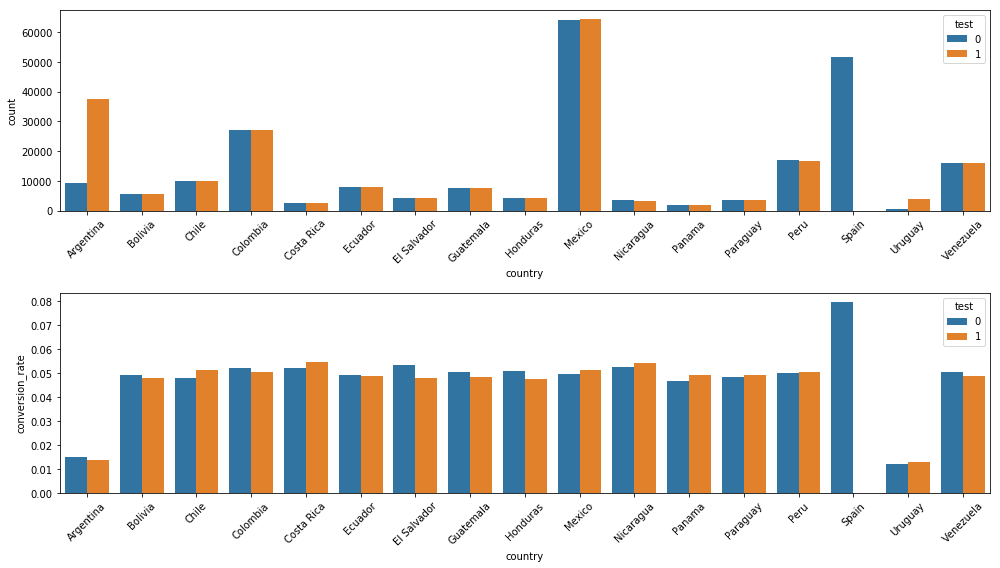

In [15]:
# Group the data by country and test
country_test = create_df(['country', 'test']).reset_index()

# Plot the distribution and conversion rates
create_plots(country_test, 'country')

It appears that the control group (non-localized translations) have higher conversion rates in a half of the countries (excluding Chile, Costa Rica, Mexico, Nicaragua, Panama, Paraguay, Peru, Spain, and Uruguay).

Regarding distribution, the key things to note is the imbalanced distribution in Argentina and Uruguay (test group consists of a larger sample than the control). This could suggest that the sample was biased and this experiment would be invalidated.

Before moving forward, let's make sure that these results are actually statistically significant (p-value < 0.05). To apply inferential statistics here, I will use bootstrapping to gather 100 samples of conversion rates. From there, I will use the 100 samples in a two-sided t-test.

Null Hypothesis: There is no difference between the translations by a local (experimental) and the translations by a Spaniard (control).

Alternate Hypothesis: There is a difference between the local and spaniard translations.

In [16]:
# Define the control and test dataframes
control_df = merged_df[merged_df['test'] == 0].copy()
exp_df = merged_df[merged_df['test'] == 1].copy()

In [17]:
# Create a list of countries excluding Spain
LIST_COUNTRIES = [country for country in user_df['country'].unique() if country != 'Spain']

In [18]:
for val in sorted(LIST_COUNTRIES):
    control_bootstrap = np.empty(100)
    test_bootstrap = np.empty(100)

    val_control_df = control_df[control_df['country'] == val]
    val_test_df = exp_df[exp_df['country'] == val]
    
    for i in range(100):
        # Define the bootstrap samples and store them in the empty arrays 
        control_bootstrap[i] = np.mean(np.random.choice(val_control_df['conversion'], len(val_control_df)))
        test_bootstrap[i] = np.mean(np.random.choice(val_test_df['conversion'], len(val_test_df)))
        
    t_test = ttest_ind(control_bootstrap, test_bootstrap)
    print ('{}:  {}'.format(val, t_test))

Argentina:  Ttest_indResult(statistic=10.925266174077207, pvalue=4.762830625101511e-22)
Bolivia:  Ttest_indResult(statistic=4.134082081518607, pvalue=5.260479159574857e-05)
Chile:  Ttest_indResult(statistic=-9.36741275037811, pvalue=1.7065337031764893e-17)
Colombia:  Ttest_indResult(statistic=8.404090515341128, pvalue=8.337083096609118e-15)
Costa Rica:  Ttest_indResult(statistic=-4.436924132391057, pvalue=1.5130206996593518e-05)
Ecuador:  Ttest_indResult(statistic=0.43500110393149055, pvalue=0.6640353848076137)
El Salvador:  Ttest_indResult(statistic=11.36280009023446, pvalue=2.3248512550738893e-23)
Guatemala:  Ttest_indResult(statistic=5.763054057772419, pvalue=3.12597542512258e-08)
Honduras:  Ttest_indResult(statistic=6.339327677003766, pvalue=1.528669772442612e-09)
Mexico:  Ttest_indResult(statistic=-16.290474812246927, pvalue=2.063435408103074e-38)
Nicaragua:  Ttest_indResult(statistic=-1.7938851223190952, pvalue=0.07435733757578016)
Panama:  Ttest_indResult(statistic=-4.7143196515

Non-significant countries: Ecuador, Nicaragua

In [19]:
# Define the list of countries that show positive change
POSITIVE = ['Chile', 'Costa Rica', 'Mexico', 'Nicaragua', 'Panama', 
            'Paraguay', 'Peru', 'Uruguay']

# Define the list of countries that show negative change
NEGATIVE = [col for col in country_test['country'].unique() if col not in POSITIVE]
NEGATIVE.remove('Spain')

In [20]:
# # Make sure the test and control data have the same date range
# for col in merged_df['country'].unique():
#     temp_df = merged_df[merged_df['country'] == col].copy()
#     temp_cont = temp_df.loc[(temp_df['test'] == 0), 'date'].copy()
#     temp_test = temp_df.loc[(temp_df['test'] == 1), 'date'].copy()
#     print (col)
#     print('Control:   Max: {}    Min:  {}'.format(temp_cont.max(),
#                                                   temp_cont.min()))
#     print('Test:   Max: {}    Min:  {}'.format(temp_test.max(),
#                                                temp_test.min()))

All test and control groups fall within the same timeframe. There doesn't seem appear to be any mistakes with the dates of the experiment.

For the remainder of this analysis, I will perform the visualizations for analysis, but comment out the code prior to submission. The purpose of doing so is to minimize the length of the notebook when uploaded. Instead, I will leave key visualizations that led to my conclusion.

In [21]:
merged_df.columns

Index(['user_id', 'date', 'source', 'device', 'browser_language',
       'ads_channel', 'browser', 'conversion', 'test', 'sex', 'age', 'country',
       'count'],
      dtype='object')

In [22]:
# Group the data by country, test, and source
source_df = create_df(['country', 'test', 'source']).reset_index()

# Show the positive countries
# source_df.loc[POSITIVE, :]

# source_df[source_df['country'].isin(POSITIVE)]

In [23]:
# Show the negative countries
# source_df.loc[NEGATIVE, :]

In [24]:
# sns.catplot(x='source', y='conversion_rate', hue='test', col='country', kind='bar', data=source_df)

In [25]:
# print ('Positive Countries:')
# for col in range(len(POSITIVE)):
#     print (POSITIVE[col])
#     fig, ax = plt.subplots(nrows=2)
#     sns.barplot(x='conversion_rate', y='source', hue='test', 
#                 data=source_df[source_df['country'] == POSITIVE[col]], 
#                 orient="h", ax=ax[0])
#     sns.barplot(x='count', y='source', hue='test', 
#                 data=source_df[source_df['country'] == POSITIVE[col]], 
#                 orient="h", ax=ax[1])
# #     plt.ylabel(POSITIVE[col])
#     plt.show()

In [26]:
# print ('Negative Countries:')
# for col in range(len(NEGATIVE)):
#     print (NEGATIVE[col])
#     fig, ax = plt.subplots(nrows=2)
#     sns.barplot(x='conversion_rate', y='source', hue='test', 
#                 data=source_df[source_df['country'] == NEGATIVE[col]], 
#                 orient="h", ax=ax[0])
#     sns.barplot(x='count', y='source', hue='test', 
#                 data=source_df[source_df['country'] == NEGATIVE[col]], 
#                 orient="h", ax=ax[1])
# #     plt.ylabel(NEGATIVE[col])
#     plt.show()

In [27]:
# Define a function to plot the data
def plot_groups(df, cat):
    '''Plot the conversion rates and distribution of newly grouped data'''
    print ('Positive Countries:')
    for col in range(len(POSITIVE)):
        print (POSITIVE[col])
        fig, ax = plt.subplots(nrows=2)
        sns.barplot(x='conversion_rate', y=cat, hue='test', 
                    data=df[df['country'] == POSITIVE[col]], 
                    orient="h", ax=ax[0])
        sns.barplot(x='count', y=cat, hue='test', 
                    data=df[df['country'] == POSITIVE[col]], 
                    orient="h", ax=ax[1])
        plt.show()
    print ('Negative Countries:')
    for col in range(len(NEGATIVE)):
        print (NEGATIVE[col])
        fig, ax = plt.subplots(nrows=2)
        sns.barplot(x='conversion_rate', y=cat, hue='test', 
                    data=df[df['country'] == NEGATIVE[col]], 
                    orient="h", ax=ax[0])
        sns.barplot(x='count', y=cat, hue='test', 
                    data=df[df['country'] == NEGATIVE[col]], 
                    orient="h", ax=ax[1])
        plt.show()

In [28]:
# Create the remainder of the dataframes
# Create the device dataframe
device_df = create_df(['country', 'test', 'device']).reset_index()

# Create the browser_language dataframe
lang_df = create_df(['country', 'test', 'browser_language']).reset_index()

# Create the ads_channel dataframe
ads_df = create_df(['country', 'test', 'ads_channel']).reset_index()

# Create the browser dataframe
browser_df = create_df(['country', 'test', 'browser']).reset_index()

# Create the sex dataframe
sex_df = create_df(['country', 'test', 'sex']).reset_index()

# Create the age dataframe
age_df = create_df(['country', 'test', 'age']).reset_index()

In [29]:
# plot_groups(device_df, 'device')

In [30]:
# plot_groups(lang_df, 'browser_language')

In [31]:
# plot_groups(ads_df, 'ads_channel')

In [32]:
# plot_groups(browser_df, 'browser')

In [33]:
# plot_groups(sex_df, 'sex')

In [34]:
# # Plot a scatterplot for the ages
# print ('Positive Countries:')
# for cat in POSITIVE:
#     print (cat)
#     fig, ax = plt.subplots(nrows=2, figsize=(10,6))
#     # Plot the conversion rates
#     sns.lineplot(x='age', y='conversion_rate', hue='test', data=age_df[age_df['country'] == cat], ax=ax[0])
#     # Plot the distribution
#     sns.lineplot(x='age', y='count', hue='test', data=age_df[age_df['country'] == cat], ax=ax[1])
#     plt.show()
    
# print ('Negative Countries:')
# for cat in NEGATIVE:
#     print (cat)
#     fig, ax = plt.subplots(nrows=2, figsize=(10,6))
#     sns.lineplot(x='age', y='conversion_rate', hue='test', data=age_df[age_df['country'] == cat], ax=ax[0])
#     sns.lineplot(x='age', y='count', hue='test', data=age_df[age_df['country'] == cat], ax=ax[1])
#     plt.tight_layout()
#     plt.show()

In [35]:
# Create the remainder of the dataframes without the countries
# Create the device dataframe
device_df = create_df(['device', 'test']).reset_index()

# Create the browser_language dataframe
lang_df = create_df(['browser_language', 'test']).reset_index()

# Create the ads_channel dataframe
ads_df = create_df(['ads_channel', 'test']).reset_index()

# Create the browser dataframe
browser_df = create_df(['browser', 'test']).reset_index()

# Create the sex dataframe
sex_df = create_df(['sex', 'test']).reset_index()

# Create the age dataframe
age_df = create_df(['age', 'test']).reset_index()

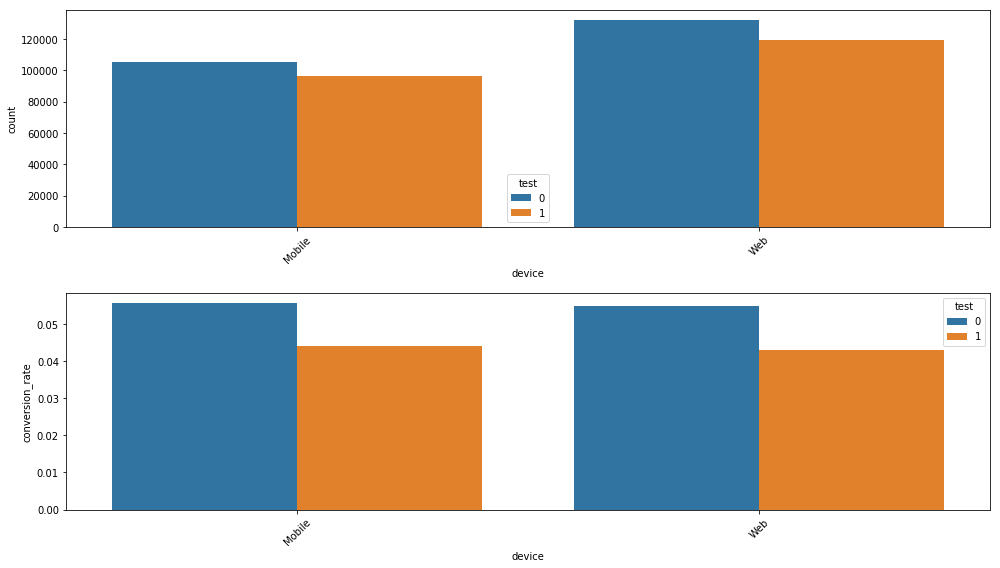

In [36]:
create_plots(device_df, 'device')

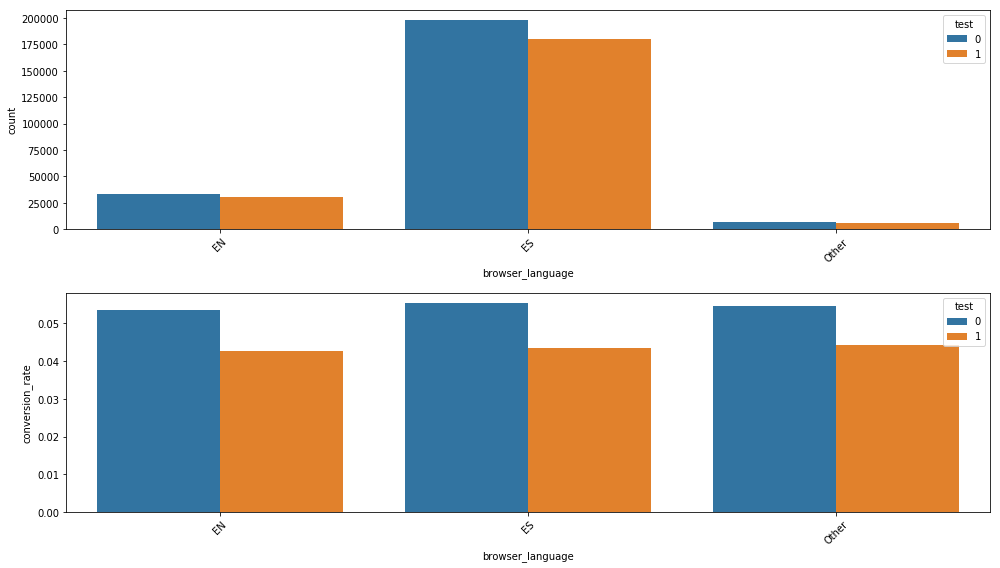

In [37]:
create_plots(lang_df, 'browser_language')

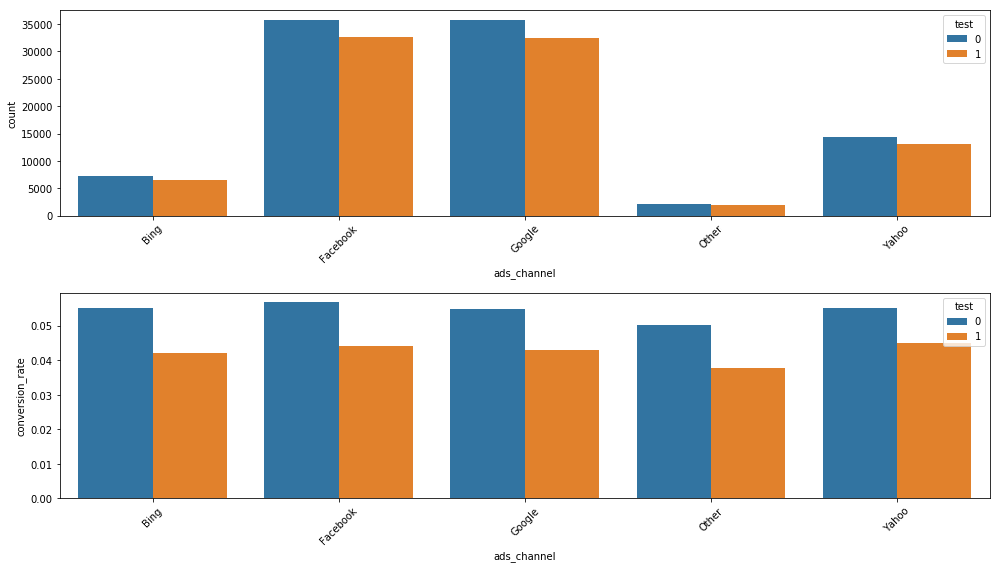

In [38]:
create_plots(ads_df, 'ads_channel')

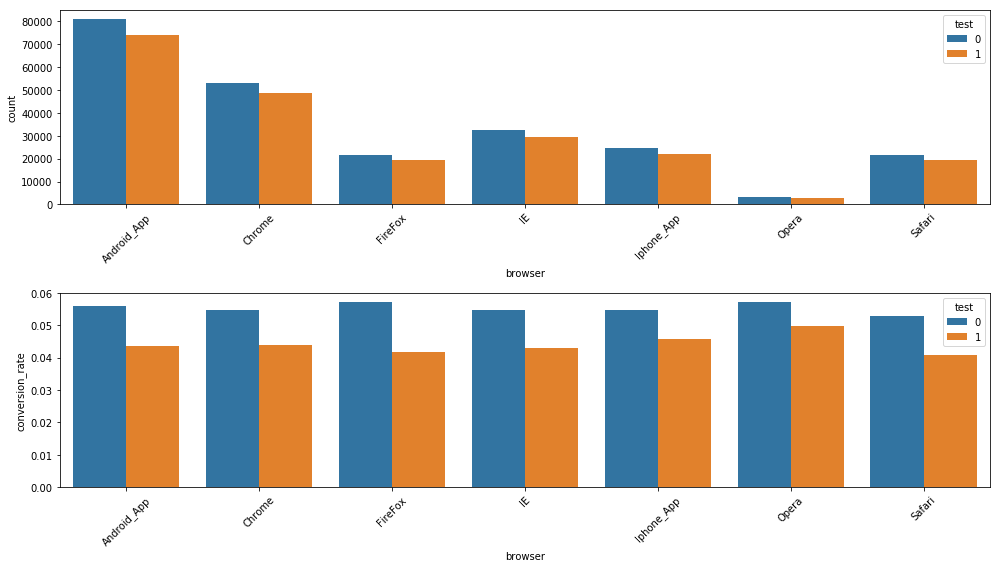

In [39]:
create_plots(browser_df, 'browser')

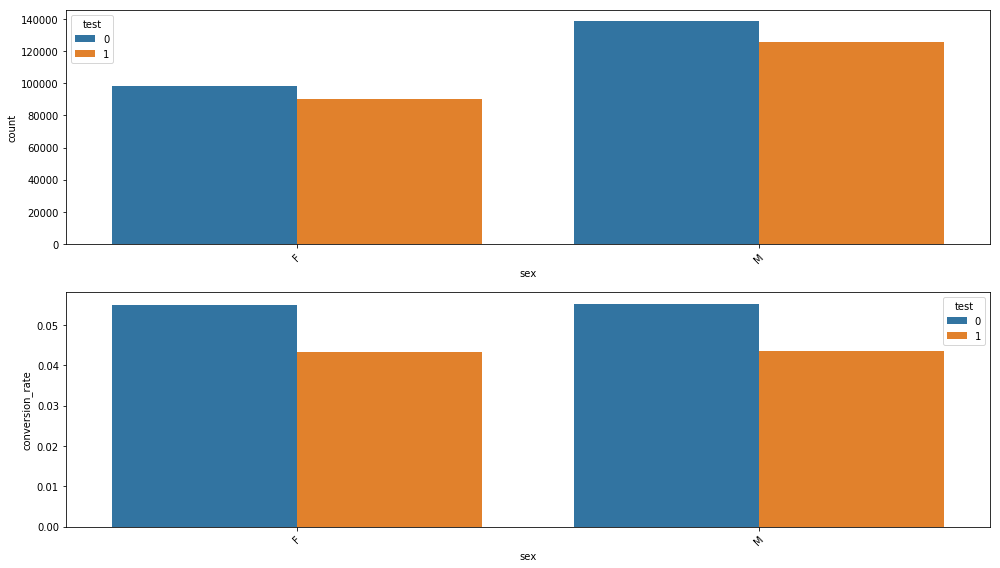

In [40]:
create_plots(sex_df, 'sex')

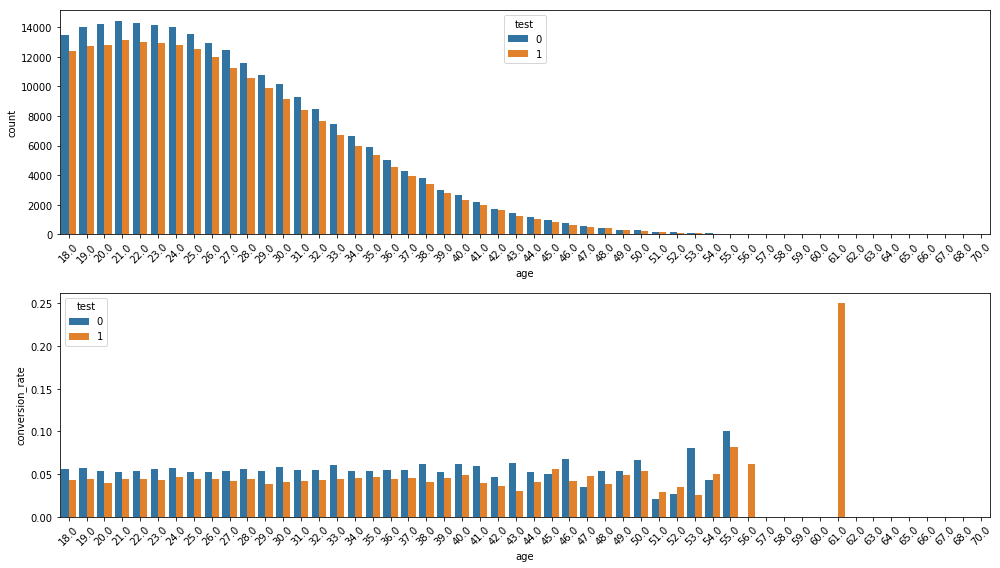

In [41]:
create_plots(age_df, 'age')

In [42]:
age_df[age_df['age'] == 61]

,age,test,conversion,count,conversion_rate
86,61.0,0,0,7,0.00
87,61.0,1,1,4,0.25


It appears that the only imbalanced sample occurs in the countries variables (Uruguay and Argentina). There does appear to be an anamoly at age 61.0. However, because the primary analysis is done across control and test groups, the anamoly has very minimal effect on the overall conversion rate.

The control (standard translation) group yields a higher conversion rate across all variables. Regarding the performance of each variable across multiple countries, there is a lot of variability so it is difficult to draw any conclusion from it.

In [43]:
# Define a function that will automatically detect imbalanced data between control and test data.
def find_imbalance(cat):
    '''Detect imbalanced data'''
    balanced = True
    new_df = merged_df.groupby([cat, 'test']).agg({'conversion':sum, 'count':sum}).reset_index()
    new_df['perc_total'] = new_df.groupby(cat)['count'].apply(lambda x: round(x / float(x.sum()), 4))
    for val in new_df[cat].unique():
        val_df = new_df[new_df[cat] == val]
        if float(val_df.loc[val_df['test'] == 0, 'perc_total']) not in [0, 1]:
            # Any distribution less than 60/40 will be considered imbalanced
            if float((val_df.loc[val_df['test'] == 0, 'perc_total']) 
                     * float(val_df.loc[val_df['test'] == 1, 'perc_total'])) < 0.024:
                print (float((val_df.loc[val_df['test'] == 0, 'perc_total']) 
                     * float(val_df.loc[val_df['test'] == 1, 'perc_total'])))
                balanced = False
        else:
            balanced = False
    if balanced == True:
        print ('The data is balanced.')
    else:
        print ('The data is imbalanced.')
               
# Note that the function does not work with the age category since some ages do not have controls or test groups 
# due to small sample sizes.

##  Conclusion:
- From my analysis of the data, there does appear to be higher conversion rates with the standarized Spanish translations. 
- However, this particular experiment should be invalidated due to biased sampling in Uruguay and Argentina. 
- Additionally, the "English" and "Other" values in the browser_language variable should be excluded from the study since the source of the Spanish translation (the experimental condition) does not affect those two values. Any result from those two values will bring more variance to the data.
- There is about an equal split in the number of countries that show positive change and negative change between the standard and local translations.